In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT
from qiskit_aer.primitives import Estimator
#from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.circuit.library import TwoLocal
import numpy as np


from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA,NFT
from qiskit.circuit.library import TwoLocal

In [2]:
def get_qubit_op_jw(dist):
    # Define Molecule
    driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 "+str(dist),
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    )
    # Get properties
    problem = driver.run()

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    
    mapper = ParityMapper()
    #tapered_mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [3]:
def exact_solver_jw(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

In [31]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_cobyla = []
vqe_energies_cobyla = []
error_cobyla = []
optimizer = COBYLA(maxiter=100)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_cobyla.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_cobyla.append(vqe_result)
    error_cobyla.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_cobyla[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 2.70996 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.15748 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.

In [32]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_spsa = []
vqe_energies_spsa = []
error_spsa = []
optimizer = SPSA(maxiter=100)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_spsa.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_spsa.append(vqe_result)
    error_spsa.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_spsa[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 3.71422 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.55301 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60008 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91202 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05332 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11571 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13597 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13328 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12050 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10101 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07915 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05651 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03513 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01538 Exact Energy: -1.01547
Interatomic Distance: 1.

In [33]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_slsqp = []
vqe_energies_slsqp = []
error_slsqp = []
optimizer = SLSQP(maxiter=100)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_slsqp.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_slsqp.append(vqe_result)
    error_slsqp.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_slsqp[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 2.70996 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.15748 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.

In [34]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_nft = []
vqe_energies_nft = []
error_nft = []
optimizer = NFT(maxiter=100)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_nft.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_nft.append(vqe_result)
    error_nft.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_nft[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 2.71589 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.16418 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.59383 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.90436 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.04300 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.10113 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.11735 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.11085 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.09191 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.06611 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.03654 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.00511 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -0.97311 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -0.94148 Exact Energy: -1.01547
Interatomic Distance: 1.

In [35]:
distances = np.arange(0.1, 4.0, 0.1)
exact_energies_bfgs = []
vqe_energies_bfgs = []
error_bfgs = []
optimizer = L_BFGS_B(maxiter=100)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op_jw(
        dist
    )

    result = exact_solver_jw(qubit_op, problem)
    exact_energies_bfgs.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies_bfgs.append(vqe_result)
    error_bfgs.append(abs(vqe_result - (-1.13619)))
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies_bfgs[-1]:.5f}",)

print("All energies have been calculated")

Interatomic Distance: 0.1 VQE Result: 2.70996 Exact Energy: 2.70996
Interatomic Distance: 0.2 VQE Result: 0.15748 Exact Energy: 0.15748
Interatomic Distance: 0.3 VQE Result: -0.60180 Exact Energy: -0.60180
Interatomic Distance: 0.4 VQE Result: -0.91415 Exact Energy: -0.91415
Interatomic Distance: 0.5 VQE Result: -1.05516 Exact Energy: -1.05516
Interatomic Distance: 0.6 VQE Result: -1.11629 Exact Energy: -1.11629
Interatomic Distance: 0.7 VQE Result: -1.13619 Exact Energy: -1.13619
Interatomic Distance: 0.8 VQE Result: -1.13415 Exact Energy: -1.13415
Interatomic Distance: 0.9 VQE Result: -1.12056 Exact Energy: -1.12056
Interatomic Distance: 1.0 VQE Result: -1.10115 Exact Energy: -1.10115
Interatomic Distance: 1.1 VQE Result: -1.07919 Exact Energy: -1.07919
Interatomic Distance: 1.2 VQE Result: -1.05674 Exact Energy: -1.05674
Interatomic Distance: 1.3 VQE Result: -1.03519 Exact Energy: -1.03519
Interatomic Distance: 1.4 VQE Result: -1.01547 Exact Energy: -1.01547
Interatomic Distance: 1.

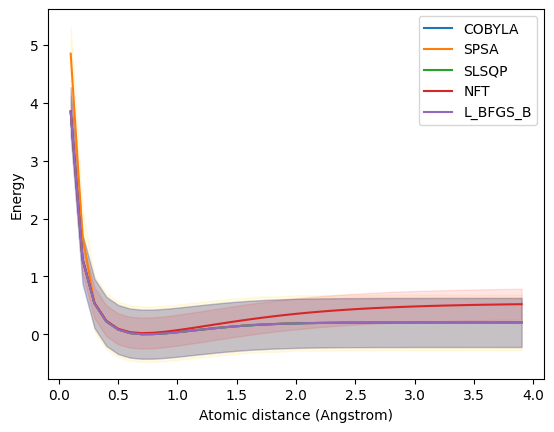

In [41]:
plt.plot(distances, error_cobyla, label="COBYLA")
ci = 0.2 * np.std(error_cobyla) / np.mean(error_cobyla)
plt.fill_between(distances, (error_cobyla-ci), (error_cobyla+ci), color='blue', alpha=0.1)

plt.plot(distances, error_spsa, label="SPSA")
ci_spsa = 0.2 * np.std(error_spsa) / np.mean(error_spsa)
plt.fill_between(distances, (error_spsa-ci_spsa), (error_spsa+ci_spsa), color='gold', alpha=0.1)

plt.plot(distances, error_slsqp,label="SLSQP")
ci_slsqp = 0.2 * np.std(error_slsqp) / np.mean(error_slsqp)
plt.fill_between(distances, (error_slsqp-ci_slsqp), (error_slsqp+ci_slsqp), color='green', alpha=0.1)

plt.plot(distances, error_nft, label="NFT")
ci_nft = 0.2 * np.std(error_nft) / np.mean(error_nft)
plt.fill_between(distances, (error_nft-ci_nft), (error_nft+ci_nft), color='red', alpha=0.1)

plt.plot(distances, error_bfgs,label="L_BFGS_B")
ci_bfgs = 0.2 * np.std(error_bfgs) / np.mean(error_bfgs)
plt.fill_between(distances, (error_bfgs-ci_bfgs), (error_bfgs+ci_bfgs), color='purple', alpha=0.1)

#plt.ylim(0,0.000000000001)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.savefig("H2_Error_Optimizer_Comparison_Noiseless.jpeg",dpi = 300)
plt.show()

In [37]:
print(error_bfgs)

[3.8461507708672737, 1.293672134798368, 0.534386289234319, 0.22204029537292103, 0.08103020552938367, 0.019903993130463205, 5.459340779445654e-07, 0.0020423333229200313, 0.015629718700029382, 0.035039669767437776, 0.056997055031082766, 0.07944925369507194, 0.10100373356611092, 0.12072175071228308, 0.138040646528802, 0.15271727096688203, 0.16476331154166313, 0.17437304720742375, 0.18185114600127306, 0.18754888782435897, 0.1918153188841658, 0.19496596631725205, 0.19726761403243986, 0.19893504701979403, 0.20013508008089897, 0.20099396919265455, 0.20160558406326956, 0.2020389043702353, 0.2023442492606241, 0.2025581554811935, 0.20270705965744307, 0.20281002268743198, 0.2028807275947443, 0.20292894257308958, 0.2029615944817046, 0.20298355805249435, 0.2029982358974991, 0.20300798325589586, 0.203014416960407]


In [38]:
print(error_cobyla)

[3.8461507913530526, 1.2936721675716014, 0.5343862977981118, 0.22204031941433922, 0.08103021340522454, 0.01990400808942705, 5.645437828327715e-07, 0.0020423357033780842, 0.01562972445456512, 0.03503967792792695, 0.05699707443447055, 0.07944925577646766, 0.10100373761405845, 0.12072176084059705, 0.1380406494521289, 0.1527172752824566, 0.16476335229236172, 0.17437307837798233, 0.181852089490671, 0.1875504664354275, 0.19185075758459336, 0.1949734487456305, 0.19726766479060553, 0.2010944408588088, 0.2005780519854612, 0.20134972591022127, 0.20170862387834432, 0.2021033044227758, 0.20265728821345308, 0.20271366118127432, 0.20270749736718952, 0.2028140370594641, 0.20288740076930922, 0.20293444661963478, 0.20296518082781356, 0.20298600164561953, 0.2029982819478855, 0.2030080133963229, 0.20301442194355002]


In [39]:
print(error_slsqp)

[3.8461507708690594, 1.2936721348015525, 0.5343862892402644, 0.22204029538457792, 0.08103020555128171, 0.01990399316955549, 5.45988830147337e-07, 0.002042333378159178, 0.015629870223972997, 0.03503968119351031, 0.05699705504511665, 0.07944925507532008, 0.10100373619267611, 0.12072175293843435, 0.13804064747789457, 0.15271727113455924, 0.16476331154687718, 0.1743733414644254, 0.1818511460026322, 0.18754888795282176, 0.19181532031761406, 0.1949659729387958, 0.19726763277698534, 0.1989350856879345, 0.20013514406023858, 0.20099405950931604, 0.201605697402357, 0.20203903450012173, 0.20234438910466113, 0.20255829879701914, 0.20270720129749786, 0.20281015919389456, 0.20288085685489687, 0.2029290635135288, 0.20296170669090274, 0.2029836616523466, 0.20299833119887434, 0.20300807063852877, 0.2030144970171751]


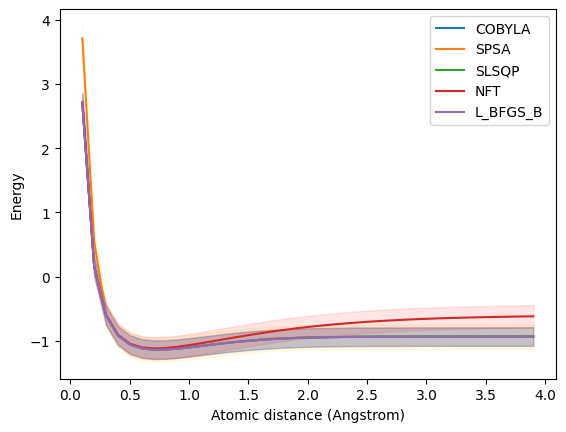

In [40]:
plt.plot(distances, vqe_energies_cobyla, label="COBYLA")
ci = 0.2 * np.std(vqe_energies_cobyla) / np.mean(vqe_energies_cobyla)
plt.fill_between(distances, (vqe_energies_cobyla-ci), (vqe_energies_cobyla+ci), color='blue', alpha=0.1)

plt.plot(distances, vqe_energies_spsa, label="SPSA")
ci = 0.2 * np.std(vqe_energies_spsa) / np.mean(vqe_energies_spsa)
plt.fill_between(distances, (vqe_energies_spsa-ci), (vqe_energies_spsa+ci), color='gold', alpha=0.1)

plt.plot(distances, vqe_energies_slsqp, label="SLSQP")
ci = 0.2 * np.std(vqe_energies_slsqp) / np.mean(vqe_energies_slsqp)
plt.fill_between(distances, (vqe_energies_slsqp-ci), (vqe_energies_slsqp+ci), color='green', alpha=0.1)

plt.plot(distances, vqe_energies_nft, label="NFT")
ci = 0.2 * np.std(vqe_energies_nft) / np.mean(vqe_energies_nft)
plt.fill_between(distances, (vqe_energies_nft-ci), (vqe_energies_nft+ci), color='red', alpha=0.1)

plt.plot(distances, vqe_energies_bfgs, label="L_BFGS_B")
ci = 0.2 * np.std(vqe_energies_bfgs) / np.mean(vqe_energies_bfgs)
plt.fill_between(distances, (vqe_energies_bfgs-ci), (vqe_energies_bfgs+ci), color='purple', alpha=0.1)
#plt.ylim(0,0.000000000001)
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.savefig("H2_VQE_Optimizer_Comparison_Noiseless.jpeg",dpi = 300)
plt.show()